In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

from penquins import Kowalski

from sklearn.model_selection import train_test_split

from matplotlib.colors import LogNorm
from astropy.stats import sigma_clipped_stats
from astropy.io.fits.verify import VerifyWarning
import warnings
warnings.filterwarnings("ignore", category=VerifyWarning)

from bson.json_util import loads, dumps
import gzip, io, sys, json
from astropy.io import fits

BOLD = "\033[1m"
END  = "\033[0m"

%matplotlib notebook

In [2]:
with open('credentials.json', 'r') as f:
    creds = json.load(f)
    
k = Kowalski(username=creds['username'], password=creds['password'])
assert(k.ping())


In [3]:
def query_kowalski(ZTFID, kowalski):
    """
        Query kowalski to get the candidate stamps
        ADAPTED FROM https://github.com/growth-astro/ztfrest/
        https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html
    """
    
    if type(ZTFID) == str:
        list_ZTFID = [ZTFID]
    elif type(ZTFID) == list:
        list_ZTFID = ZTFID
    else:
        print(f"{ZTFID} must be a list or a string")
        return None

    alerts = []
    
    for ZTFID in list_ZTFID:
        query = {
            "query_type": "find",
            "query": {
                "catalog": "ZTF_alerts",
                "filter": {
                    'objectId': ZTFID
                },
                "projection": {
                    "_id": 0,
                    "candid": 1,
                    "objectId": 1,
#                     "candidate": 1,
                    "candidate.magpsf": 1,
                    "candidate.sigmapsf": 1,
                    "candidate.magzpsci": 1, 
                    "candidate.magzpsciunc": 1,
                    "cutoutScience": 1,
                    "cutoutTemplate": 1,
                    "cutoutDifference": 1,
                }
            }
        }

        r = kowalski.query(query)

        if r['data'] == []:
            print("  No data for", ZTFID)
        else:
            alerts += r['data']
            print("  Finished querying", ZTFID)
    print(BOLD+f"Finished all queries, got {len(alerts)} alerts"+END+"\n")
    return alerts
    sh
    

def make_triplet(alert, normalize: bool = False):
    """
        Feed in alert packet
        ADAPTED FROM https://github.com/dmitryduev/braai
    """
    

    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        # loads(dumps(dict)) effectively converts all keys to strings
        # not sure what packing in list and removing is for
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']['stampData']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])
                    
        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        if shape != (63, 63):
            cutout_dict[cutout] = np.pad(cutout_dict[cutout],
                                         [(0, 63 - shape[0]),
                                          (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']

    return triplet


def plot_triplet(tr, show_fig: bool = True):
    """ADAPTED FROM https://github.com/dmitryduev/braai"""
    
    fig = plt.figure(figsize=(8, 2), dpi=120)
    ax1 = fig.add_subplot(131)
    ax1.axis('off')
    mean, median, std = sigma_clipped_stats(tr[:, :, 0])
    ax1.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax1.title.set_text('Science')
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    mean, median, std = sigma_clipped_stats(tr[:, :, 1])
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax2.title.set_text('Reference')
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    mean, median, std = sigma_clipped_stats(tr[:, :, 2])
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    ax3.title.set_text('Difference')

    if show_fig:
        plt.show()
    else:
        return fig
    


In [4]:
alerts = query_kowalski("ZTF22aaolwsd", k)


  Finished querying ZTF22aaolwsd
Finished all queries, got 107 alerts



In [9]:
sci = np.asarray(make_triplet(alerts[34])[:,:,0])
ref = np.asarray(make_triplet(alerts[34])[:,:,1])
dif = np.asarray(make_triplet(alerts[34])[:,:,2])

In [15]:
sci

array([[ 94.94637299,  94.05736542,  92.91439819, ..., 104.20713806,
        104.07482147, 104.6108551 ],
       [ 93.33679962,  91.53807831,  98.37638855, ..., 114.59857941,
        107.17646027, 118.85970306],
       [ 98.83932495,  99.79019165,  97.19432831, ..., 110.34346771,
        115.61916351, 115.4771347 ],
       ...,
       [122.66300201, 125.23880005, 130.60662842, ..., 142.15361023,
        133.47190857, 135.11242676],
       [105.47809601, 105.82418823, 113.10485077, ..., 142.10066223,
        132.51605225, 129.02311707],
       [110.83435059,  99.99108887,  99.15312195, ..., 144.77964783,
        129.87086487, 127.89550781]])

In [16]:
ref

array([[ 96.57775116,  95.84381866,  96.81417847, ..., 106.6853714 ,
        105.28969574, 106.45981598],
       [ 96.45365143,  94.19350433,  95.52172089, ..., 108.65448761,
        106.51197815, 106.97775269],
       [ 96.22286987,  95.32538605,  94.30340576, ..., 110.45450592,
        109.36315918, 111.26826477],
       ...,
       [152.67288208, 141.10549927, 127.77320099, ..., 143.01544189,
        139.91897583, 134.51506042],
       [118.05937195, 116.72444916, 114.06079102, ..., 137.30366516,
        132.56092834, 129.99676514],
       [108.64713287, 111.61443329, 108.52584076, ..., 133.51922607,
        129.9151001 , 126.88246155]])

In [17]:
dif

array([[ -2.57749104,  -2.32532573,  -3.94018459, ...,  -2.62859488,
         -2.24038506,  -2.6644547 ],
       [ -1.84297907,  -2.24497128,   2.15923095, ...,   5.81151295,
          0.1046593 ,  11.55326557],
       [  1.32462275,   3.88839579,   2.9516418 , ...,  -1.06671071,
          5.68225098,   1.47922921],
       ...,
       [  3.32423854,  -4.67680407,  -1.59011078, ...,  -1.86715484,
         -6.15651321,   1.60507512],
       [ -4.10938025, -11.50473309,  -5.89242458, ...,   8.20157528,
          1.73972225,  -1.40786362],
       [ 10.77403641,  -5.36819124,  -8.53859425, ...,  10.32632351,
          0.97617346,   2.69490218]])

<IPython.core.display.Javascript object>


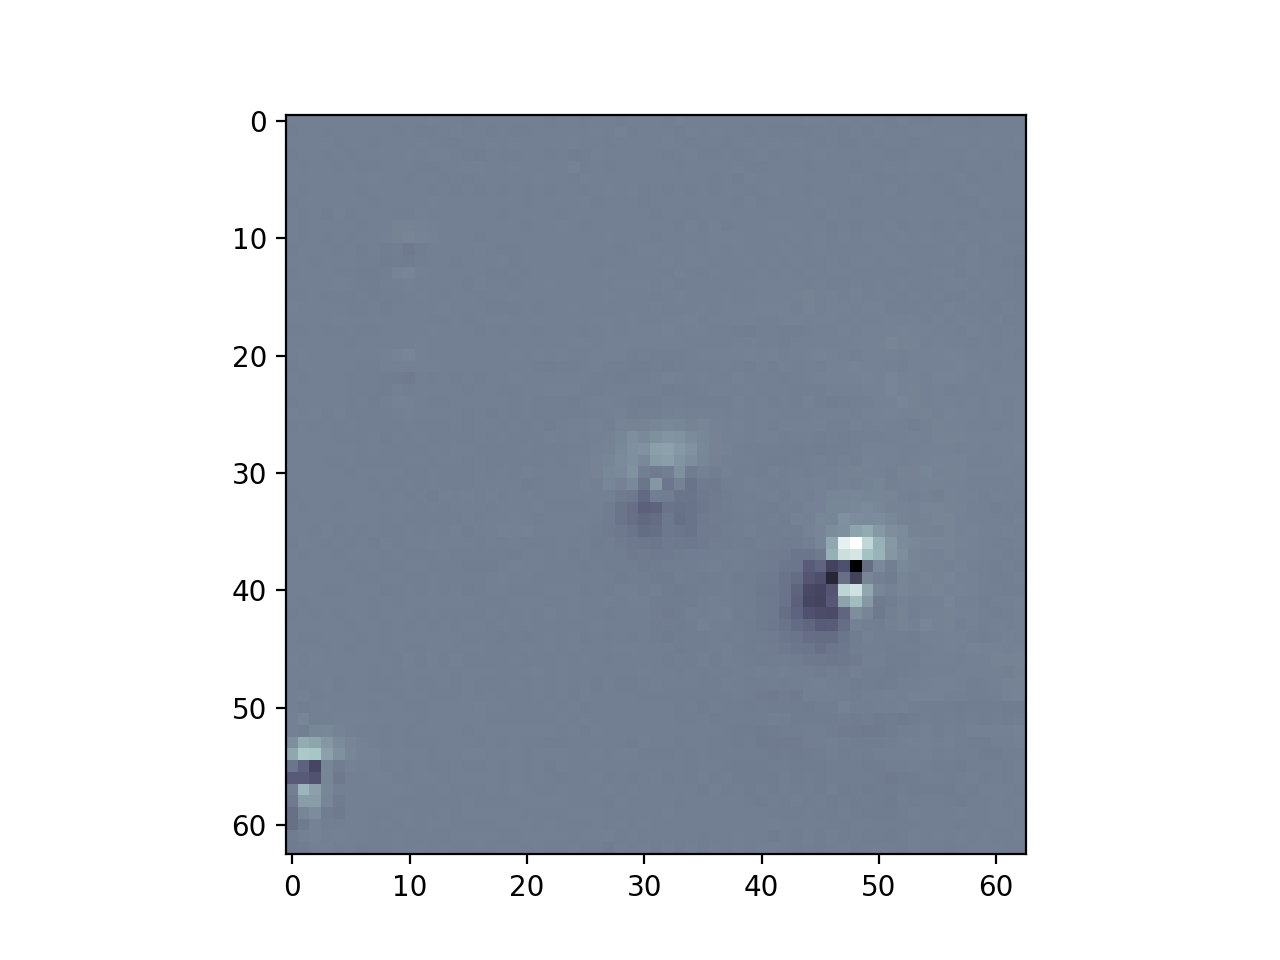

In [19]:
(sci-ref)-dif

plt.figure()
plt.imshow((sci-ref)-dif, origin='upper', cmap=plt.cm.bone)
plt.show()

<IPython.core.display.Javascript object>


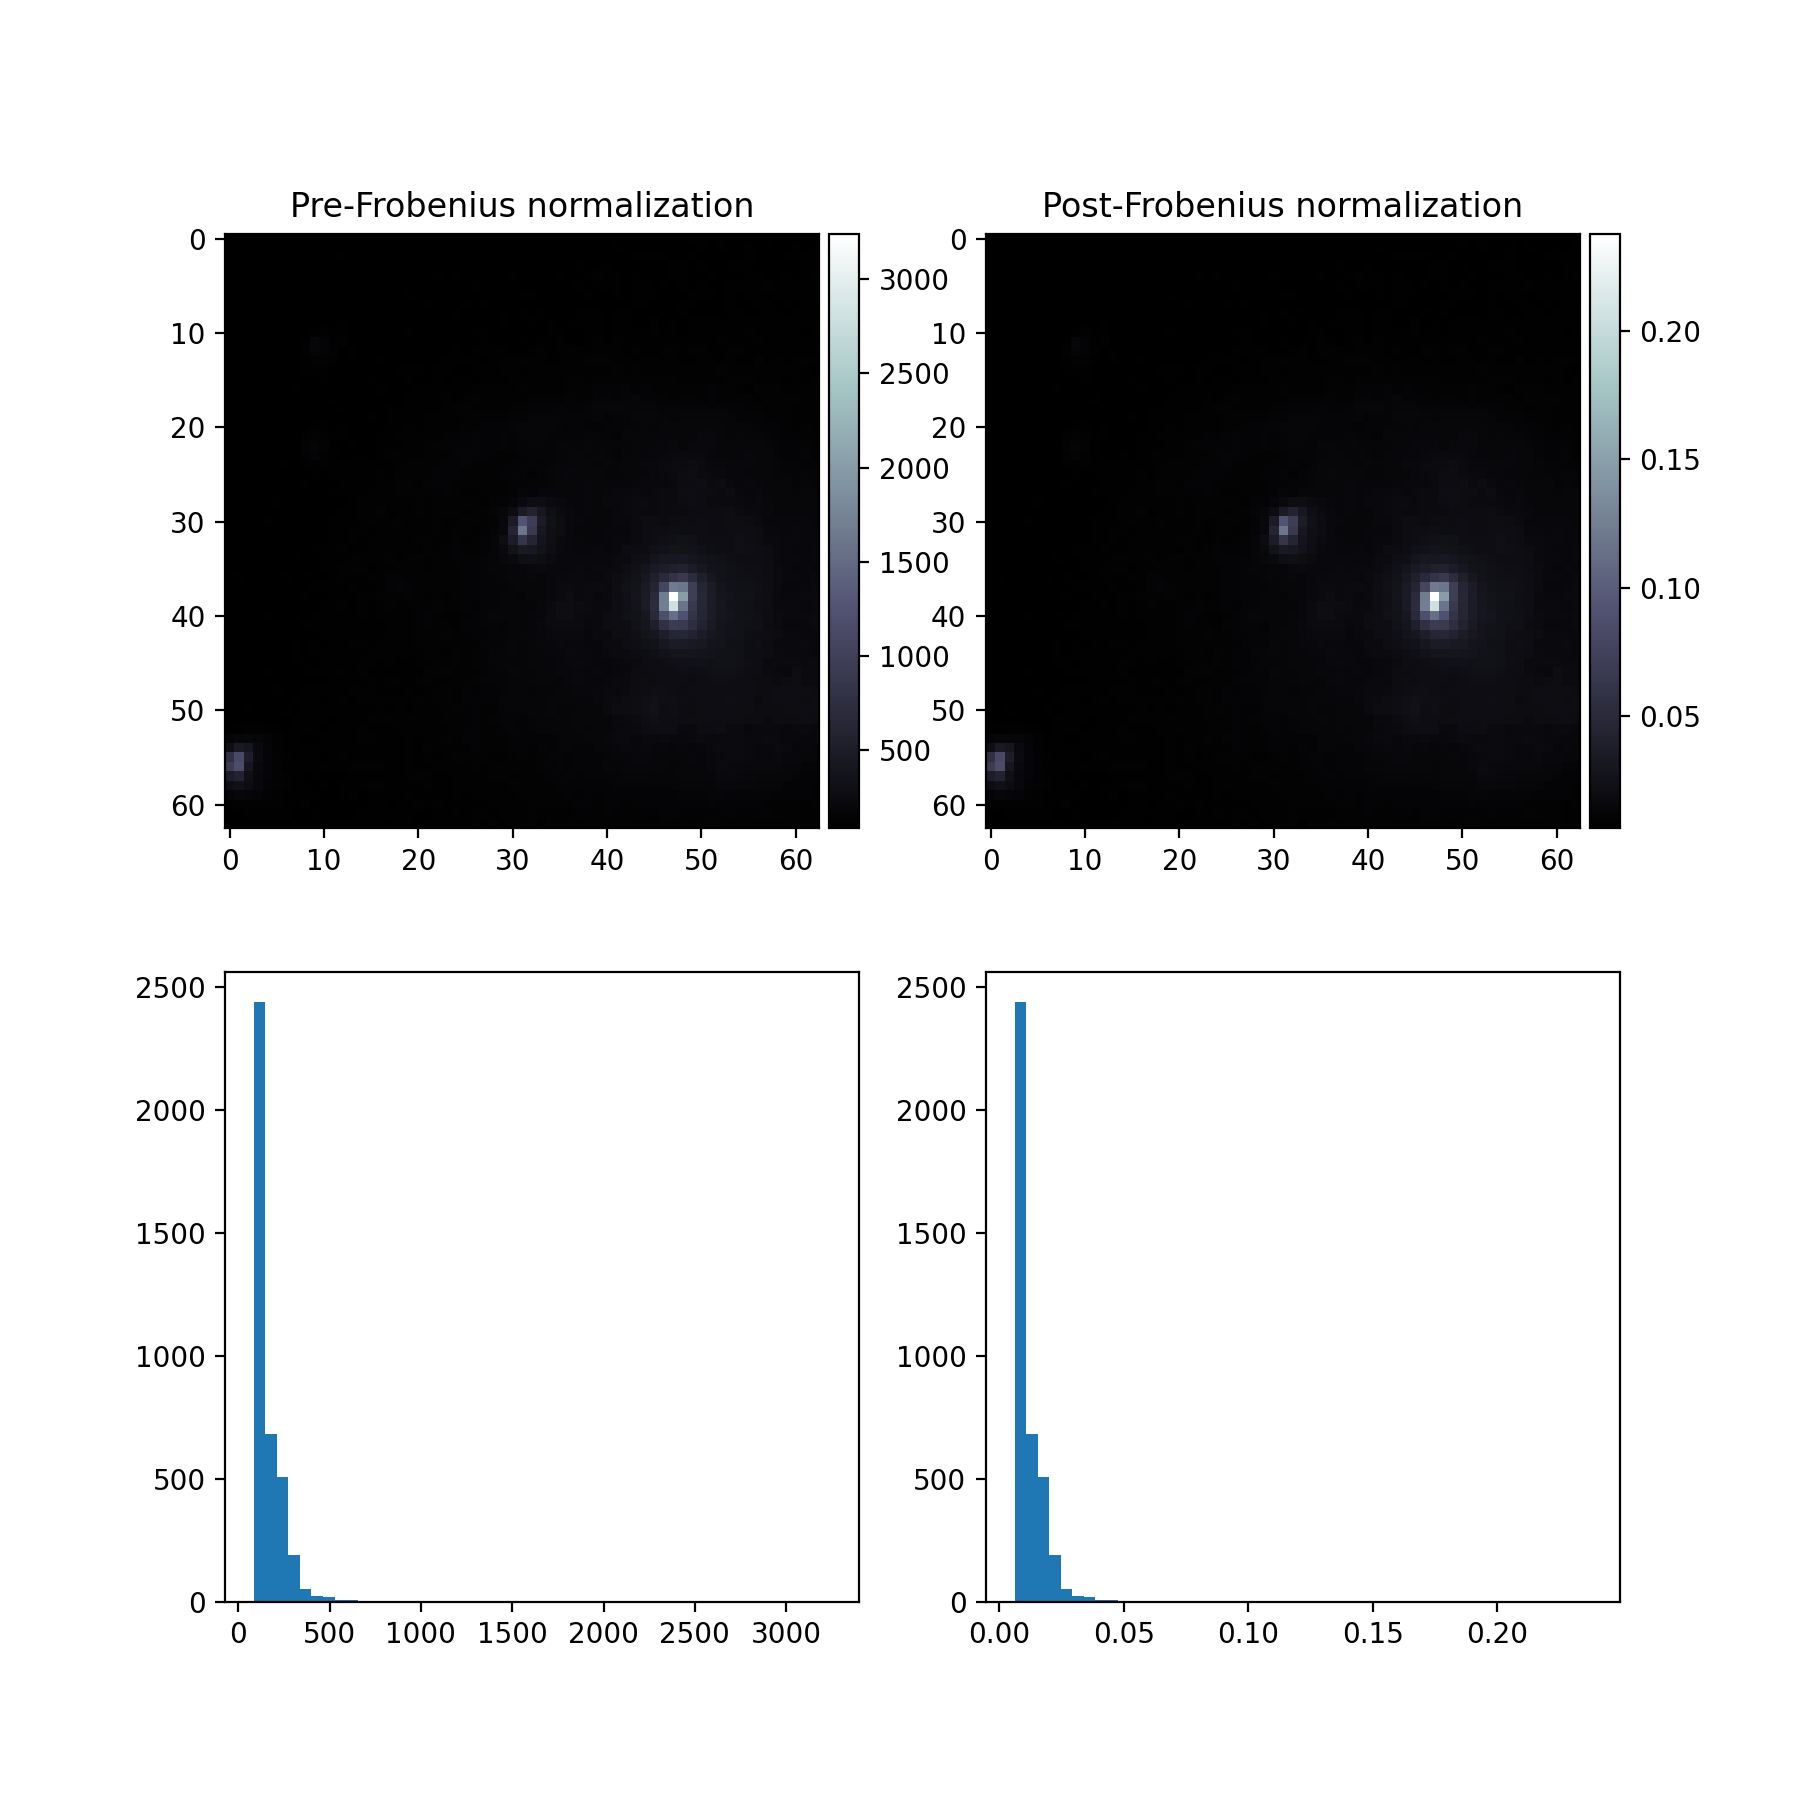

In [6]:
# Dividing by Frobenius (constant) is just a remapping but done because it puts all images on same playing field
# Still throwing away absolute brightness information so modification is necessary
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(9,9))

ax1.set_title("Pre-Frobenius normalization")
im1 = ax1.imshow(make_triplet(alert)[:, :, 0], origin='upper', cmap=plt.cm.bone)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

ax2.set_title("Post-Frobenius normalization")
im2 = ax2.imshow(make_triplet(alert, normalize=True)[:, :, 0], origin='upper', cmap=plt.cm.bone)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

ax3.hist(make_triplet(alert)[:, :, 0].flatten(), bins=50)

ax4.hist(make_triplet(alert, normalize=True)[:, :, 0].flatten(), bins=50)

plt.show()


In [ ]:
# m = -2.5log(c)+zp

# 12=-2.5log(255)+zp



# m1-m2=-2.5log(f1/f2)

# 12+2.5*np.log10(255)


<IPython.core.display.Javascript object>


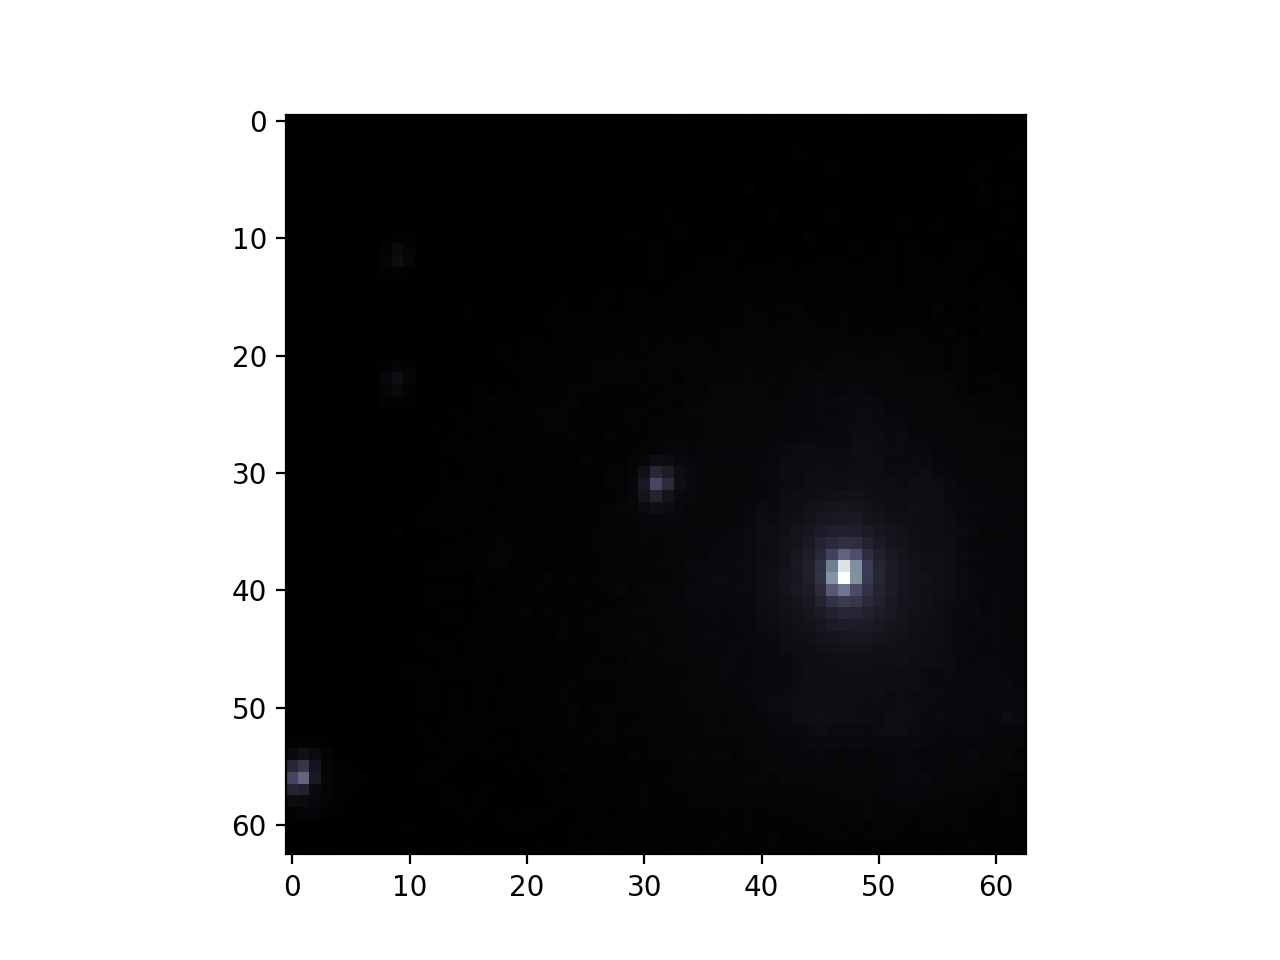

In [26]:
alert = alerts[50]

plt.figure()
plt.imshow(make_triplet(alert)[:, :, 0], origin='upper', cmap=plt.cm.bone)
plt.show()

In [19]:
print(alert['candidate'])

{'magpsf': 16.221168518066406, 'sigmapsf': 0.036385565996170044, 'magzpsci': 26.185169219970703, 'magzpsciunc': 8.18090029497398e-06}


In [25]:
-2.5*np.log10(9514.031372070312)+26.18516921

16.239257762120396

In [28]:
12 + 2.5*np.log10(1)

12.0

In [30]:
20 + 2.5*np.log10(1e-10)

-5.0

In [9]:
for alert in alerts:
    alert

In [31]:
for alert in alerts:
    cutout_data = loads(dumps([alert[f'cutoutScience']['stampData']]))[0]

    with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdu:
            data = np.nan_to_num(hdu[0].data)
            
            print(data)
            
            
#             cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])


[[ 72.80737   81.55505   82.16431  ... 115.89905   87.11011   97.16498 ]
 [ 95.70624   69.95758   81.80444  ...  90.54132   89.20062   96.139465]
 [ 89.0401    97.11841   63.993103 ...  96.28265  122.09247   91.21533 ]
 ...
 [121.4137   124.297424 105.11084  ... 112.974304 115.57147  137.42554 ]
 [113.703     92.9613   104.168884 ... 124.74042   96.07428  121.07562 ]
 [ 80.24005   84.76788  106.82556  ... 115.285706 113.36444  125.07703 ]]
[[177.90552 203.54752 187.70996 ... 224.11154 207.64792 230.13235]
 [209.84167 197.83112 185.37112 ... 229.44235 210.12936 205.46872]
 [188.9779  188.23804 202.26001 ... 229.74496 212.04453 225.92526]
 ...
 [238.16254 258.47406 258.80423 ... 276.84442 284.8875  256.36945]
 [220.7962  217.61774 244.23703 ... 277.4032  256.0843  275.66888]
 [184.50925 190.30981 218.43503 ... 258.85767 267.2245  262.75708]]
[[184.47069 170.64622 185.58742 ... 201.97227 203.72386 200.22745]
 [179.52278 186.64272 171.13579 ... 188.57307 198.16216 197.01288]
 [191.1844  17